<a href="https://colab.research.google.com/github/jacr2006/image-classification/blob/master/Notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
from torchvision import models
from torchvision import transforms
import torch
from torch.utils.data import dataset
from torchvision import datasets
from torch.utils.data import  DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
import matplotlib.pyplot as plt

### Data set
date used was downloaded from [CalTech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/(opens%20in%20a%20new%20tab)) , only 10 classes are used: bear, chimp, giraffe, gorilla, llama, ostrich, porcupine, skunk, triceratops and zebra.

In [35]:
PATH = "/content/drive/My Drive/Proyectos Nuevos/ML/image_classification_pytorch/Data/"

In [36]:
# Set train and valid directory paths
train_directory = PATH+'train'
valid_directory = PATH+'valid'
test_directory = PATH+'test'

In [37]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [38]:
!tree "/content/drive/My Drive/Proyectos Nuevos/ML/image_classification_pytorch/Data/" -d -L 4

/content/drive/My Drive/Proyectos Nuevos/ML/image_classification_pytorch/Data/
├── test
│   ├── bear
│   ├── chimp
│   ├── giraffe
│   ├── gorilla
│   ├── llama
│   ├── ostrich
│   ├── porcupine
│   ├── skunk
│   ├── triceratops
│   └── zebra
├── train
│   ├── bear
│   ├── chimp
│   ├── giraffe
│   ├── gorilla
│   ├── llama
│   ├── ostrich
│   ├── porcupine
│   ├── skunk
│   ├── triceraptops
│   └── zebra
└── valid
    ├── bear
    ├── chimp
    ├── giraffe
    ├── gorilla
    ├── llama
    ├── ostrich
    ├── porcupine
    ├── skunk
    ├── triceratops
    └── zebra

33 directories


### Data preparing
data is splitted into train, valid and test set, and data of each one was prepared according to model used

In [39]:
# Number of classes
num_classes = 10

In [40]:
# Applying Transforms to the Data
# rotation, flip and resizing for augmentation
# normalization in the same way that training of model was done, normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


### Data loading

In [41]:
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

In [42]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

In [43]:
# Batch size
bs = 32
# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)


In [44]:
# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size

(600, 100, 409)

### Tranfer learning to model

In [45]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

In [46]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [47]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)


In [48]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet50.to(device)


In [50]:
loss_criterion = nn.CrossEntropyLoss()

### Train model

In [52]:
epochs = 4
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
     
    # Set to training mode
    model.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    for i, (inputs, labels) in enumerate(train_data):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
         
        # Compute loss
        loss = loss_criterion(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
         
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

Epoch: 1/4
Batch number: 000, Training: Loss: 0.2645, Accuracy: 0.9688
Batch number: 001, Training: Loss: 0.2635, Accuracy: 1.0000
Batch number: 002, Training: Loss: 0.4769, Accuracy: 0.8438
Batch number: 003, Training: Loss: 0.1852, Accuracy: 0.9375
Batch number: 004, Training: Loss: 0.2251, Accuracy: 0.9375
Batch number: 005, Training: Loss: 0.2575, Accuracy: 1.0000
Batch number: 006, Training: Loss: 0.2844, Accuracy: 0.9688
Batch number: 007, Training: Loss: 0.1804, Accuracy: 0.9688
Batch number: 008, Training: Loss: 0.2581, Accuracy: 0.9688
Batch number: 009, Training: Loss: 0.2317, Accuracy: 0.9375
Batch number: 010, Training: Loss: 0.2236, Accuracy: 0.9688
Batch number: 011, Training: Loss: 0.1417, Accuracy: 1.0000
Batch number: 012, Training: Loss: 0.2888, Accuracy: 0.9062
Batch number: 013, Training: Loss: 0.3387, Accuracy: 0.9375
Batch number: 014, Training: Loss: 0.2256, Accuracy: 0.9375
Batch number: 015, Training: Loss: 0.1410, Accuracy: 0.9688
Batch number: 016, Training: 

### Validation

In [54]:
history = []

# Validation - No gradient tracking needed
with torch.no_grad():

    # Set to evaluation mode
    model.eval()

    # Validation loop
    for j, (inputs, labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_criterion(outputs, labels)

        # Compute the total loss for the batch and add it to valid_loss
        valid_loss += loss.item() * inputs.size(0)

        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * inputs.size(0)

        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_size 
avg_train_acc = train_acc/float(train_data_size)

# Find average training loss and training accuracy
avg_valid_loss = valid_loss/valid_data_size 
avg_valid_acc = valid_acc/float(valid_data_size)

history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        
epoch_end = time.time()

print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


Validation Batch number: 000, Validation: Loss: 0.2897, Accuracy: 0.8750
Validation Batch number: 001, Validation: Loss: 0.0779, Accuracy: 0.9688
Validation Batch number: 002, Validation: Loss: 0.1925, Accuracy: 0.9688
Validation Batch number: 003, Validation: Loss: 0.0595, Accuracy: 1.0000
Epoch : 003, Training: Loss: 0.2158, Accuracy: 92.6667%, 
		Validation : Loss : 0.3632, Accuracy: 188.0000%, Time: 1178.6933s


### Inference

In [70]:
idx_to_class = {
    1: "bear",
    2: "chimp",
    3: "giraffe",
    4: "gorilla",
    5: "llama",
    6: "ostrich",
    7: "porcupine",
    8: "shunk",
    9: "triceraptos",
    10: "zebra"
}

def predict(model, test_image_name):
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[1+topclass.cpu().numpy()[0][0]])


In [71]:
TEST = "/content/drive/My Drive/Proyectos Nuevos/ML/image_classification_pytorch/Data/test/bear/009_0071.jpg"

Output class :   bear


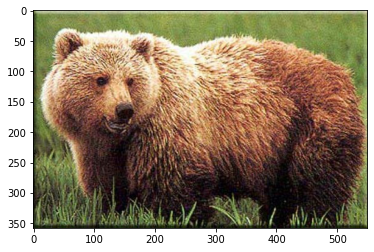

In [72]:
predict(model, TEST)